In [119]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [120]:
df = pd.read_csv('rawdata/USvideos.csv')

In [121]:
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [122]:
df = df.drop(columns=['description', 'video_id', 'thumbnail_link', 'video_error_or_removed'])
df

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled
0,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,False,False
1,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,False,False
2,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,False,False
3,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,False,False
4,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
40944,18.14.06,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18T13:00:04.000Z,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,2657,False,False
40945,18.14.06,True Facts : Ant Mutualism,zefrank1,22,2018-05-18T01:00:06.000Z,[none],1064798,60008,382,3936,False,False
40946,18.14.06,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18T17:34:22.000Z,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,False,False
40947,18.14.06,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17T17:00:04.000Z,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,False,False


# Feature Engineering

In [123]:
import seaborn as sns

# feature list
# trending_date	,trending_date, title, channel_title, category_id, publish_time,tags , views, likes , dislikes , comment_count, comments_disabled,ratings_disabled

# engineering publish_time

df['at_what_hour'] = pd.to_datetime(df['publish_time']).dt.hour
df['dayofweek'] = pd.to_datetime(df['publish_time']).dt.dayofweek

# engineering trending_date

df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m').dt.tz_localize('UTC')
df['how_long_till_trending'] = (df['trending_date'] - pd.to_datetime(df['publish_time'])).dt.total_seconds()


# engineering comments_disabled, ratings_disabled

df['comments_disabled'] = df['comments_disabled'].astype(int)
df['ratings_disabled'] = df['ratings_disabled'].astype(int)


df.drop(columns=['publish_time', 'trending_date', 'category_id'], inplace=True)

# Normalize numeric features
numeric_features = ['views', 'likes', 'dislikes', 'comment_count', 'at_what_hour', 'dayofweek', 'how_long_till_trending']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])



In [125]:
df

,title,channel_title,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,at_what_hour,dayofweek,how_long_till_trending
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,SHANtell martin,0.003321,0.010247,0.001771,0.011717,0,0,0.739130,0.000000,0.000196
1,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,"last week tonight trump presidency|""last week ...",0.010738,0.017312,0.003671,0.009330,0,0,0.304348,0.000000,0.000292
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",0.014168,0.026013,0.003189,0.006008,0,0,0.826087,1.000000,0.000414
3,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,"rhett and link|""gmm""|""good mythical morning""|""...",0.001521,0.001812,0.000398,0.001576,0,0,0.478261,0.000000,0.000257
4,I Dare You: GOING BALD!?,nigahiga,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",0.009303,0.023555,0.001188,0.012866,0,0,0.782609,1.000000,0.000425
...,...,...,...,...,...,...,...,...,...,...,...,...
40944,The Cat Who Caught the Laser,AaronsAnimals,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",0.007482,0.006798,0.000827,0.001951,0,0,0.565217,0.666667,0.006405
40945,True Facts : Ant Mutualism,zefrank1,[none],0.004726,0.010689,0.000228,0.002891,0,0,0.043478,0.666667,0.006524
40946,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,I gave safiya nygaard a perfect hair makeover ...,0.004733,0.008562,0.000616,0.002932,0,0,0.739130,0.666667,0.006360
40947,How Black Panther Should Have Ended,How It Should Have Ended,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",0.025133,0.034372,0.001700,0.009612,0,0,0.739130,0.500000,0.006603


# Vector Embedding

In [ ]:
# make vector embedding using sentence transformers
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('all-MiniLM-L6-v2')
title_embedding = model.encode(df['title'].astype(str).tolist(), show_progress_bar=True)
channel_title_embedding= model.encode(df['channel_title'].astype(str).tolist(), show_progress_bar=True)
tags_embedding = model.encode(df['tags'].astype(str).tolist(), show_progress_bar=True)


c:\Users\25194\Desktop\SubCancelationPrediction\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\25194\Desktop\SubCancelationPrediction\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\25194\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run 

# Saving Embedding vectors

In [ ]:
# concatenate embeddings with the dataframe

print(title_embedding.shape)
print(channel_title_embedding.shape)
print(tags_embedding.shape)


np.save('title_embedding.npy', title_embedding)
np.save('channel_title_embedding.npy', channel_title_embedding)
np.save('tags_embedding.npy', tags_embedding)

(40949, 384)
(40949, 384)
(40949, 384)


# Concatenateing the embedded features with normal numeric features

In [ ]:

X = np.concatenate((title_embedding, channel_title_embedding, tags_embedding, df[numeric_features].values), axis=1)
Y = df['views'].values


(40949,)

# Splitting for training 

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
Y_test.shape

(8190,)

# XGboost 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

xgb_model  = XGBRegressor(n_estimators=100,random_state=42 ,tree_method='hist', device='cuda')


xgb_model.fit(X_train, Y_train)
xgb_y_pred = xgb_model.predict(X_test)
print("XGBoost MSE:", mean_squared_error(Y_test, xgb_y_pred))
print("XGBoost R^2 Score:", r2_score(Y_test, xgb_y_pred))

XGBoost MSE: 1.2308138375000951e-05
XGBoost R^2 Score: 0.9870351981025479


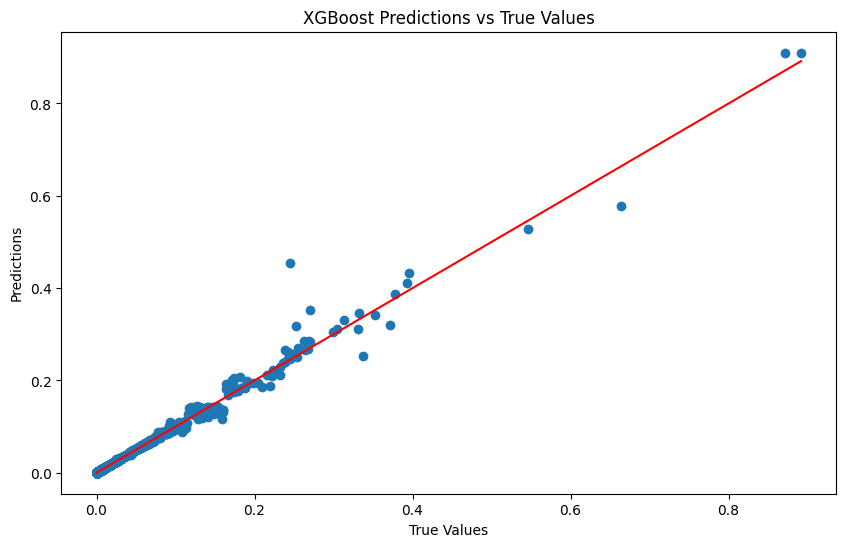

In [176]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, xgb_y_pred, alpha=1)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('XGBoost Predictions vs True Values')
plt.show()

In [180]:

test_df= pd.read_csv('rawdata/CAvideos.csv')

In [181]:
test_df.isnull().sum()
test_df = test_df.drop(columns=['description', 'video_id', 'thumbnail_link', 'video_error_or_removed'])

test_df['at_what_hour'] = pd.to_datetime(test_df['publish_time']).dt.hour
test_df['dayofweek'] = pd.to_datetime(test_df['publish_time']).dt.dayofweek

# engineering trending_date

test_df['trending_date'] = pd.to_datetime(test_df['trending_date'], format='%y.%d.%m').dt.tz_localize('UTC')
test_df['how_long_till_trending'] = (test_df['trending_date'] - pd.to_datetime(test_df['publish_time'])).dt.total_seconds()


# engineering comments_disabled, ratings_disabled

test_df['comments_disabled'] = test_df['comments_disabled'].astype(int)
test_df['ratings_disabled'] = test_df['ratings_disabled'].astype(int)


test_df.drop(columns=['publish_time', 'trending_date', 'category_id'], inplace=True)

# Normalize numeric features
numeric_features = ['views', 'likes', 'dislikes', 'comment_count', 'at_what_hour', 'dayofweek', 'how_long_till_trending']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
test_df[numeric_features] = scaler.fit_transform(test_df[numeric_features])

test_df


,title,channel_title,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,at_what_hour,dayofweek,how_long_till_trending
0,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",0.124474,0.155823,0.027097,0.112919,0,0,0.739130,0.666667,0.001093
1,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",0.007356,0.025289,0.001053,0.011688,0,0,0.739130,0.000000,0.000273
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",0.023147,0.028899,0.003332,0.007339,0,0,0.826087,1.000000,0.000523
3,I Dare You: GOING BALD!?,nigahiga,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",0.015199,0.026169,0.001241,0.015714,0,0,0.782609,1.000000,0.000535
4,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",0.243197,0.323376,0.013157,0.076307,0,0,0.478261,0.500000,0.001434
...,...,...,...,...,...,...,...,...,...,...,...,...
40876,HOW2: How to Solve a Mystery,Annoying Orange,"annoying orange|""funny""|""fruit""|""talking""|""ani...",0.000580,0.000337,0.000062,0.001177,0,0,0.782609,0.333333,0.000262
40877,Eli Lik Lik Episode 13 Partie 01,Elhiwar Ettounsi,"hkayet tounsia|""elhiwar ettounsi""|""denya okhra...",0.000744,0.000091,0.000041,0.000046,0,0,0.826087,0.333333,0.000250
40878,KINGDOM HEARTS III – SQUARE ENIX E3 SHOWCASE 2...,Kingdom Hearts,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Froze...",0.005605,0.005125,0.000140,0.003481,0,0,0.739130,0.000000,0.000814
40879,Trump Advisor Grovels To Trudeau,The Young Turks,"180612__TB02SorryExcuse|""News""|""Politics""|""The...",0.000831,0.000419,0.000114,0.001500,0,0,0.173913,0.333333,0.000421
